<left>
    <img src="https://upload.wikimedia.org/wikipedia/commons/f/f3/Logo_SYGNET.png" width="90" alt="cognitiveclass.ai logo">
</left>

<left>
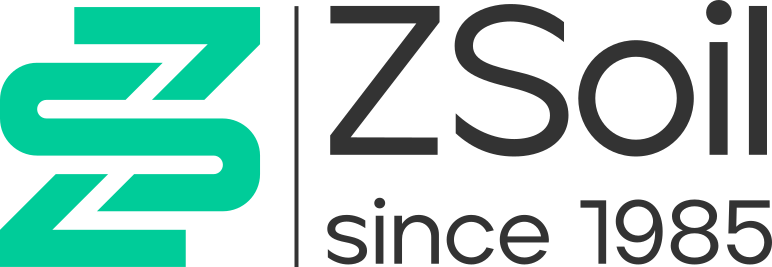
</left>

<center>
    <img src="https://upload.wikimedia.org/wikipedia/commons/2/2d/Tensorflow_logo.svg" width="200" alt="cognitiveclass.ai logo">
</center>



# CPT Data Preprocessing

Preprocessing the results from <i>Cone Penetrometer Test</i> (CPT) for ZSOIL model.

## Objectives

To import, clean, interpolate and combine the results of ZSOIL model simulation into one Dataset. The operations involve:

*   Data Wrangling with Python
*   Statistics

<center>
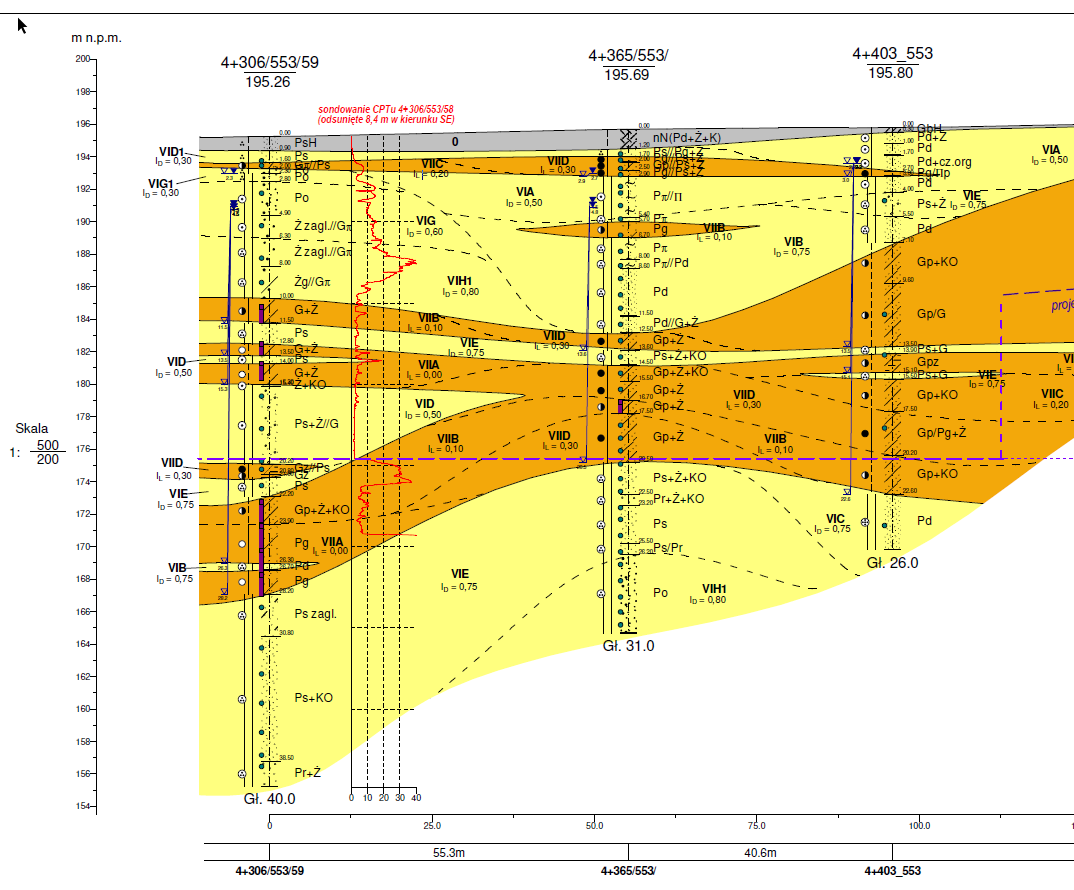
</center>
To preprocess the CPT data for use in ZSOIL, we need to extract relevant soil parameters and organize them in a format suitable for input into the software.

#### Step-by-Step Preprocessing of CPT Data

Extract Relevant Data:
        depth, cone resistance (qc), sleeve friction (fs), and pore pressure (u2) from the CPT data.
        
Calculate Soil Parameters:
        Use empirical correlations to calculate soil parameters such as density, cohesion, friction angle, and stiffness from         the CPT data.
        
Organize Data by Soil Layers:
        Identify distinct soil layers based on the variations in CPT data.
        Calculate average soil parameters for each identified layer.
        
Format Data for ZSOIL:
        Prepare the soil parameters in a format that ZSOIL can accept for defining material properties.

#### Resulting Data

The resulting <i>processed_cpt_data_for_zsoil.csv</i> file will contain average soil properties for each identified layer, formatted for input into ZSOIL.

### Preprocessing Steps Explanation

<b>1.Data Preprocessing:</b> The data is read, cleaned, and converted to a <i>DataFrame</i>, ensuring numerical conversion.

<b>2.Extract Relevant Columns:</b> <i>depth, qc, fs</i>, and <i>u2</i> columns are extracted.

<b>3.Empirical Correlations:</b> Calculate <i>phi, c, E</i>, and <i>gamma</i>.

<b>4.Create Processed DataFrame:</b> Combine extracted and calculated columns into a new <i>DataFrame</i>.

<b>5.Define Depth Layers:</b> Use numpy to create bins for depth layers and assign labels.

<b>6.Group by Layers:</b> Aggregate the data by these layers, calculating mean values for each property.

<b>7.Flatten Columns:</b> Flatten the multi-index columns resulting from the aggregation.

<b>8.Write to CSV:</b> Save the processed and grouped data to a new CSV file.

This code will process your CPT data, group it into depth layers, calculate the mean properties for each layer, and save the results to a new CSV file. Adjust <i>bin_edges</i> and <i>layer_labels</i> if you need a different number of layers or specific depth ranges.

In [2]:
import pandas as pd
import numpy as np

In [3]:
# File path to the CSV
file_path = '4+306-553-58.csv'
output_path = 'processed_cpt_data_for_ZSOIL.csv'

In [6]:
# Open the file and read lines
with open(file_path, 'r', encoding='utf-8') as file:
    lines = file.readlines()

# Skip the initial metadata lines and start from the line with headers
start_line = 41  # Adjust this if necessary
data_lines = lines[start_line:]

# Process the headers separately to get column names
header_line = data_lines[1].replace('"', '').strip().split('\t')
columns = ["Depth", "qc", "fs", "u2", "Ix", "Iy", "Channel 6", "Channel 7", "Channel 8", "Speed"]

# Initialize a list to store the cleaned data
cleaned_data = []

# Process each line in the data
for line in data_lines[2:]:  # Skip the header and unit lines
    # Remove extra quotes and split by tab
    cleaned_line = line.replace('"', '').strip().split('\t')
    # Append cleaned line to data list
    cleaned_data.append(cleaned_line)

# Convert the cleaned data to a DataFrame
df = pd.DataFrame(cleaned_data, columns=columns)

# Convert data to numeric where possible
df = df.apply(pd.to_numeric, errors='coerce')

In [11]:
# Extract relevant columns
try:
    depth = df['Depth']
    qc = df['qc']
    fs = df['fs']
    u2 = df['u2']

    # Define empirical correlations (example correlations, adjust as needed)
    phi = np.log(qc + 1) * 10  # Added 1 to avoid log(0) issues
    c = fs * 0.1
    E = qc * 2
    gamma = np.full_like(depth, 18)

    # Create a DataFrame to store processed data
    processed_data = pd.DataFrame({
        'Depth': depth,
        'qc': qc,
        'fs': fs,
        'u2': u2,
        'phi': phi,
        'c': c,
        'E': E,
        'gamma': gamma
    })

    # Print the first few rows to verify
    print(processed_data.head())

 # Define depth layers
    bin_edges = np.linspace(depth.min(), depth.max(), num=11)  # 10 layers
    layer_labels = [f'Layer {i+1}' for i in range(len(bin_edges)-1)]
    processed_data['Layer'] = pd.cut(processed_data['Depth'], bins=bin_edges, labels=layer_labels, include_lowest=True)

    # Group by layers and calculate mean values for each layer
    grouped_data = processed_data.groupby('Layer').agg({
        'Depth': ['min', 'max'],
        'phi': 'mean',
        'c': 'mean',
        'E': 'mean',
        'gamma': 'mean'
    }).reset_index()

    # Flatten multi-index columns
    grouped_data.columns = ['Layer', 'Depth_min', 'Depth_max', 'phi', 'c', 'E', 'gamma']

   # Print the grouped data to verify
    print(grouped_data)

# Write the processed data to a new CSV file
    grouped_data.to_csv(output_path, index=False)

    print(f"Processed data has been written to {output_path}")

except KeyError as e:
    print(f"KeyError: {e}. Available columns are: {df.columns}")   

   Depth    qc     fs    u2       phi       c     E  gamma
0   0.00  0.00 -0.027  0.01  0.000000 -0.0027  0.00   18.0
1   0.01  0.01 -0.053  0.01  0.099503 -0.0053  0.02   18.0
2   0.02  0.01 -0.040  0.02  0.099503 -0.0040  0.02   18.0
3   0.03  0.02 -0.040  0.03  0.198026 -0.0040  0.04   18.0
4   0.04  0.03 -0.040  0.05  0.295588 -0.0040  0.06   18.0


<ipython-input-11-0cfc9a98ef90>:35: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_data = processed_data.groupby('Layer').agg({


      Layer  Depth_min  Depth_max        phi          c          E  gamma
0   Layer 1       0.00       2.47   9.864854   1.585941   5.316774   18.0
1   Layer 2       2.48       4.95  23.572146   7.728183  20.591048   18.0
2   Layer 3       4.96       7.43  28.062362   8.722640  31.649758   18.0
3   Layer 4       7.44       9.90  29.174417  18.408357  42.516518   18.0
4   Layer 5       9.91      12.38  15.677594   7.940644   7.903790   18.0
5   Layer 6      12.39      14.86  16.572821   9.545036   9.427419   18.0
6   Layer 7      14.87      17.33  12.836061   6.043649   5.317652   18.0
7   Layer 8      17.34      19.81  10.541211   3.133854   3.744032   18.0
8   Layer 9      19.82      22.29  28.160277  13.293453  39.353629   18.0
9  Layer 10      22.30      24.77  22.257344  15.649844  23.391532   18.0
Processed data has been written to processed_cpt_data_for_ZSOIL.csv


#### Using Processed Data in ZSOIL

Define Soil Layers:
        Use the average depth ranges to define soil layers in ZSOIL.

Input Soil Properties:
        Enter the averaged soil properties (phi, c, E, gamma) for each layer into ZSOIL’s material definition.

Validate and Calibrate:
        Validate the input data with field observations or additional testing.


By following this process, we can preprocess the CPT data to extract relevant soil parameters and prepare it for use in ZSOIL, facilitating accurate soil modeling for our TBM tunneling simulation.